In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import ParameterSampler
import matplotlib.pyplot as plt

In [3]:
# ---------------------- 1. Load dữ liệu ----------------------
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/btc_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.drop('Date', axis=1, inplace=True)

# ---------------------- 2. Chuẩn hóa ----------------------
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [4]:
# ---------------------- 3. Hàm tạo chuỗi thời gian ----------------------
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])  # Giá trị cần dự đoán: priceUSD
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(data_scaled, window_size)

In [5]:
# ---------------------- 4. Chia dữ liệu 80-10-10 ----------------------
total_size = len(X)
train_end = int(total_size * 0.8)
val_end = int(total_size * 0.9)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

In [6]:
# ---------------------- 5. Random Search ----------------------
param_grid = {
    'units': [32, 64, 96, 128],
    'batch_size': [16, 32],
    'epochs': [50],
    'learning_rate': [0.001, 0.0005],
    'dropout': [0.0, 0.2, 0.5]
}

param_list = list(ParameterSampler(param_grid, n_iter=48, random_state=42))

best_model = None
best_val_loss = float('inf')
best_params = None

for params in param_list:
    print(f"Training with params: {params}")

    model = Sequential([
        SimpleRNN(params['units'], input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(params['dropout']),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(loss='mse', optimizer=optimizer)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    val_loss = model.evaluate(X_val, y_val, verbose=0)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = params

print("Best hyperparameters:", best_params)

Training with params: {'units': 32, 'learning_rate': 0.001, 'epochs': 50, 'dropout': 0.0, 'batch_size': 16}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with params: {'units': 64, 'learning_rate': 0.001, 'epochs': 50, 'dropout': 0.0, 'batch_size': 16}
Training with params: {'units': 96, 'learning_rate': 0.001, 'epochs': 50, 'dropout': 0.0, 'batch_size': 16}
Training with params: {'units': 128, 'learning_rate': 0.001, 'epochs': 50, 'dropout': 0.0, 'batch_size': 16}
Training with params: {'units': 32, 'learning_rate': 0.0005, 'epochs': 50, 'dropout': 0.0, 'batch_size': 16}
Training with params: {'units': 64, 'learning_rate': 0.0005, 'epochs': 50, 'dropout': 0.0, 'batch_size': 16}
Training with params: {'units': 96, 'learning_rate': 0.0005, 'epochs': 50, 'dropout': 0.0, 'batch_size': 16}
Training with params: {'units': 128, 'learning_rate': 0.0005, 'epochs': 50, 'dropout': 0.0, 'batch_size': 16}
Training with params: {'units': 32, 'learning_rate': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
Training with params: {'units': 64, 'learning_rate': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
Training with params: 

In [7]:
# ---------------------- 6. Đánh giá mô hình ----------------------
from sklearn.metrics import r2_score
def evaluate_model(model, X, y, dataset_name="Dataset"):
    y_pred = model.predict(X)
    y_true_rescaled = scaler.inverse_transform(
        np.concatenate([y.reshape(-1, 1), np.zeros((len(y), df.shape[1]-1))], axis=1)
    )[:,0]
    y_pred_rescaled = scaler.inverse_transform(
        np.concatenate([y_pred, np.zeros((len(y_pred), df.shape[1]-1))], axis=1)
    )[:,0]

    mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
    mape = np.mean(np.abs((y_true_rescaled - y_pred_rescaled) / y_true_rescaled)) * 100
    rmse = np.sqrt(mean_squared_error(y_true_rescaled, y_pred_rescaled))
    r2 = r2_score(y_true_rescaled, y_pred_rescaled)

    print(f"📊 {dataset_name:<9} - MAE: {mae:.2f}, MAPE: {mape:.4f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    return y_pred_rescaled, y_true_rescaled

print(f"✅ Best Parameters: units={best_params['units']}, batch_size={best_params['batch_size']}, "
      f"epochs={best_params['epochs']}, lr={best_params['learning_rate']}, dropout={best_params['dropout']}")

# Evaluate train, validation, test
y_train_pred_rescaled, y_train_true = evaluate_model(best_model, X_train, y_train, "Train")
y_val_pred_rescaled, y_val_true = evaluate_model(best_model, X_val, y_val, "Validate")
y_test_pred_rescaled, y_test_true = evaluate_model(best_model, X_test, y_test, "Test")

✅ Best Parameters: units=96, batch_size=16, epochs=50, lr=0.0005, dropout=0.0
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
📊 Train     - MAE: 795.54, MAPE: 98.9172, RMSE: 881.81, R²: 0.9906
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📊 Validate  - MAE: 1234.64, MAPE: 2.6857, RMSE: 1609.95, R²: 0.9711
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 Test      - MAE: 1112.11, MAPE: 4.4484, RMSE: 1357.75, R²: 0.9798


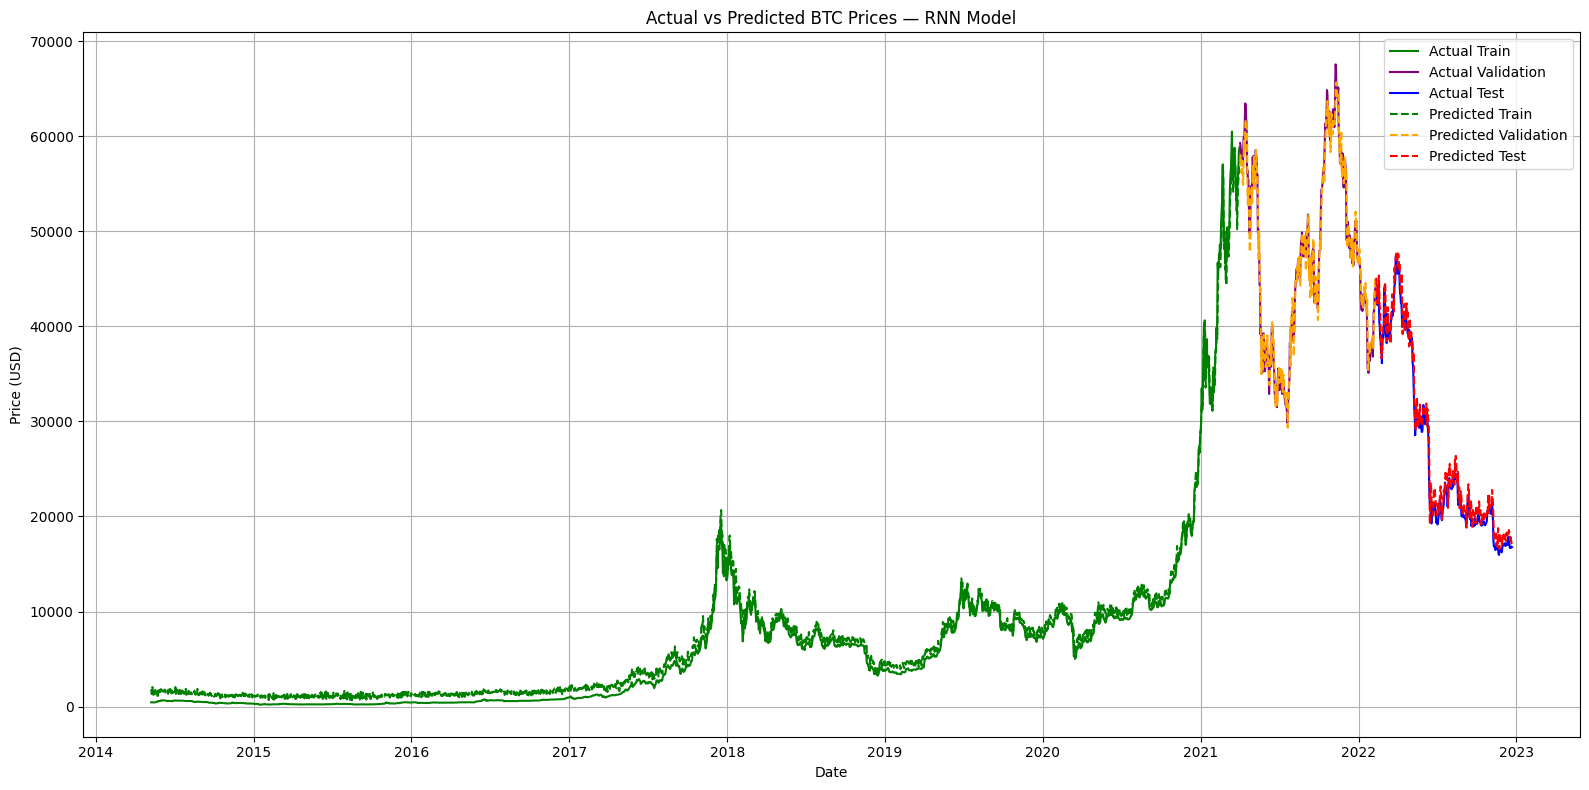

In [8]:
# ---------------------- 8. Vẽ biểu đồ chi tiết ----------------------
# Load lại ngày và cắt đúng theo từng phần dữ liệu
dates = pd.read_csv('/content/drive/My Drive/Colab Notebooks/btc_data.csv', parse_dates=['Date'])['Date']
dates = dates.sort_values().reset_index(drop=True)[window_size:]
date_train = dates[:train_end]
date_val = dates[train_end:val_end]
date_test = dates[val_end:]

plt.figure(figsize=(16,8))
plt.plot(date_train, y_train_true, color='green', label='Actual Train')
plt.plot(date_val, y_val_true, color='purple', label='Actual Validation')
plt.plot(date_test, y_test_true, color='blue', label='Actual Test')

plt.plot(date_train, y_train_pred_rescaled, color='green', linestyle='dashed', label='Predicted Train')
plt.plot(date_val, y_val_pred_rescaled, color='orange', linestyle='dashed', label='Predicted Validation')
plt.plot(date_test, y_test_pred_rescaled, color='red', linestyle='dashed', label='Predicted Test')

plt.title('Actual vs Predicted BTC Prices — RNN Model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

    Actual Price  Predicted Price
0        43185.0     45103.997975
1        42333.0     43836.310041
2        42336.0     42390.152649
3        42232.0     44355.315829
4        43867.0     42842.897766
5        43998.0     42205.577382
6        42666.0     45336.343869
7        40411.0     43721.226987
8        40065.0     41943.380867
9        38767.0     41926.303872
10       38507.0     39713.961817
11       37400.0     38719.064237
12       38221.0     36630.098861
13       36117.0     38504.505877
14       38813.0     37503.442273
15       39217.0     39063.048883
16       38714.0     40064.742738
17       39337.0     39953.629865
18       43632.0     40072.944032
19       44055.0     44091.577808


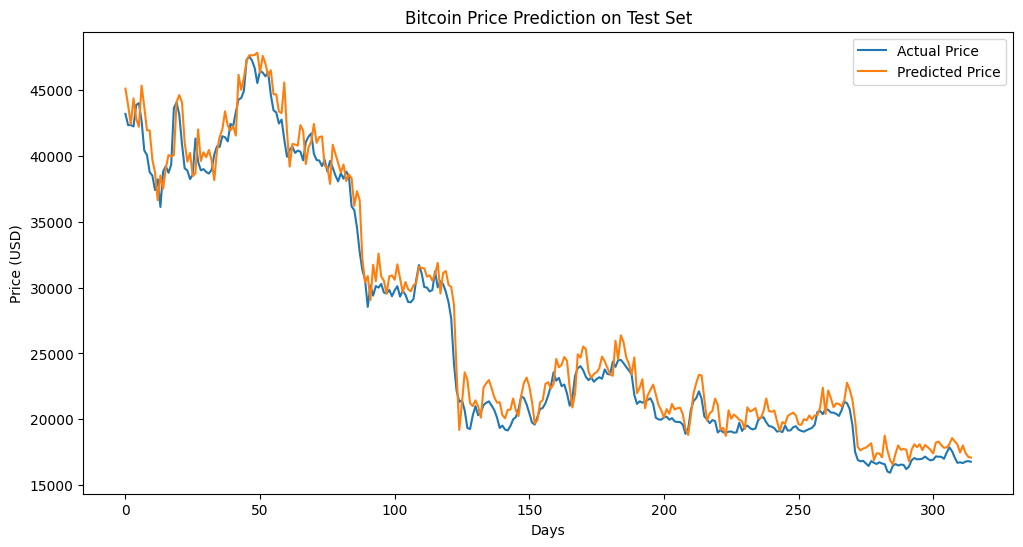

In [9]:
# ---------------------- 7. Vẽ và in bảng so sánh ----------------------
result_df = pd.DataFrame({
    'Actual Price': y_test_true,
    'Predicted Price': y_test_pred_rescaled
})
print(result_df.head(20))

plt.figure(figsize=(12,6))
plt.plot(y_test_true, label='Actual Price')
plt.plot(y_test_pred_rescaled, label='Predicted Price')
plt.title("Bitcoin Price Prediction on Test Set")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [12]:
%cd /content/drive/My Drive/Colab Notebooks
!jupyter nbconvert --to html RNN.ipynb

/content/drive/My Drive/Colab Notebooks
[NbConvertApp] Converting notebook RNN.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 579083 bytes to RNN.html
